## Heirarchical Drift Diffusion Model Analysis

In this script, we fit a version of the diffusion model that takes participant-level variabibility into account. As Wiecki et al. (2013) put it, 

"Hierarchical Bayesian methods provide a remedy for this problem by allowing group and subject parameters to be estimated simultaneously at different hierarchical levels ([LeeWagenmakers13], [Kruschke10], [VandekerckhoveTuerlinckxLee11]). Subject parameters are assumed to be drawn from a group distribution, and to the degree that subject are similar to each other, the variance in the group distribution will be estimated to be small, which reciprocally has a greater influence on constraining parameter estimates of any individual. Even in this scenario, the method still allows the posterior for any given individual subject to differ substantially from that of the rest of the group given sufficient data to overwhelm the group prior. Thus the method capitalizes on statistical strength shared across the individuals, and can do so to different degrees even within the same sample and model, depending on the extent to which subjects are similar to each other in one parameter vs. another."

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hddm
%matplotlib inline

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [13]:
# Loading and arranging data for analysis
data = hddm.load_csv("../../../data/3_final_merged_data/speed_acc_kids_ewma_results.csv")
data = data.dropna(subset = ['RT'])
data['subj_idx'] = data['Sub.Num']
data['rt'] = data['RT']
data['response'] = data['correct']

In [25]:
data_adults = hddm.load_csv("../../../data/3_final_merged_data/speed_acc_adult_ewma_results.csv")
data_adults = data_adults.dropna(subset = ['RT'])
data_adults['subj_idx'] = data_adults['subid']
data_adults['rt'] = data_adults['RT']
data_adults['response'] = data_adults['correct']

In [15]:
# Separate adult and kid data
data_kids = data[data.age_code == "child"]
# filter to remove extreme RTs
data_kids = data_kids[(data_kids.guess == "response")]
# remove object and bullseye data
data_kids = data_kids[(data_kids['stimuli'] == "Face") | (data_kids['stimuli'] == "ASL") ]

In [31]:
data_kids = hddm.utils.flip_errors(data_kids)
data_kids.head(5)

,Sub.Num,Tr.Num,stimuli,age_code,correct,Months,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
72,30024,29,ASL,child,1,21,0.733,ASL,0.733,response,1.0,0.00,cs,0.56,30024,1
73,30029,21,ASL,child,1,35,0.733,ASL,0.733,response,1.0,0.00,cs,0.56,30029,1
74,30010,13,ASL,child,1,44,0.767,ASL,0.767,response,1.0,0.01,cs,0.57,30010,1
75,30018,12,ASL,child,0,18,0.767,ASL,-0.767,response,1.0,0.00,cs,0.56,30018,0
76,30018,23,ASL,child,0,18,0.767,ASL,-0.767,response,1.0,0.00,cs,0.56,30018,0


In [45]:
# filter to remove extreme RTs
data_adults = data_adults[(data_adults.guess == "response")]
data_adults = hddm.utils.flip_errors(data_adults)
data_adults.head(5)

,subid,tr.num,shift_accuracy,rt,response_onset_type,condition,correct,RT,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
172,11_16_04,64,correct,0.463,noun,bullseye,1.0,0.463,response,1.0,0.0,cs,0.60,11_16_04,1.0
173,11_16_04,71,correct,0.463,noun,bullseye,1.0,0.463,response,1.0,0.0,cs,0.60,11_16_04,1.0
174,11_16_04,72,correct,0.463,noun,bullseye,1.0,0.463,response,1.0,0.0,cs,0.60,11_16_04,1.0
175,10_20_02,54,incorrect,-0.477,noun,bullseye,0.0,0.477,response,1.0,0.0,cs,0.60,10_20_02,0.0
189,10_20_05,53,correct,0.493,noun,bullseye,1.0,0.493,response,1.0,0.0,cs,0.61,10_20_05,1.0


## Fit variable drift model

Here we fit the ddm for each participant, but now we allow the drift rate to vary across the four conditions. We also consider the possibility that 5% of the data could be generated by a different process (i.e., outliers). From the HDDM documentation:

"What we can do instead is fit a mixture model which assumes that outliers come from a uniform distribution. (Note, outliers do not have to be very fast or very slow, and the above example is just an obvious illustration. Some proportion of the trials can be assumed to simply come from a different process for which we make no assumptions about its generation, and hence use a uniform distribution. This allows the model to find the best DDM parameters that capture the majority of trials). Here, we specify that we expect roughly 5% outliers in our data."

In [11]:
m_stim = hddm.HDDM(data_kids, depends_on={'v': 'stimuli', 'a': 'stimuli'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=100)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 134.7 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


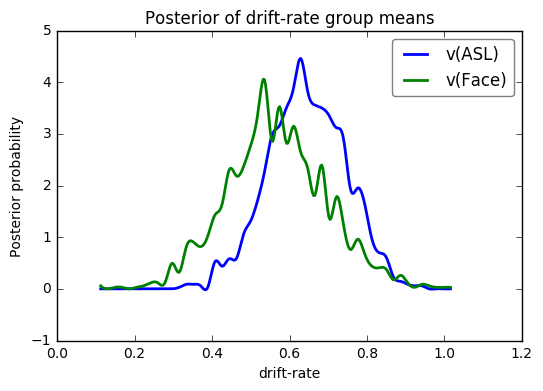

In [12]:
drift_ASL, drift_Face = m_stim.nodes_db.node[['v(ASL)', 'v(Face)']]
hddm.analyze.plot_posterior_nodes([drift_ASL, drift_Face])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

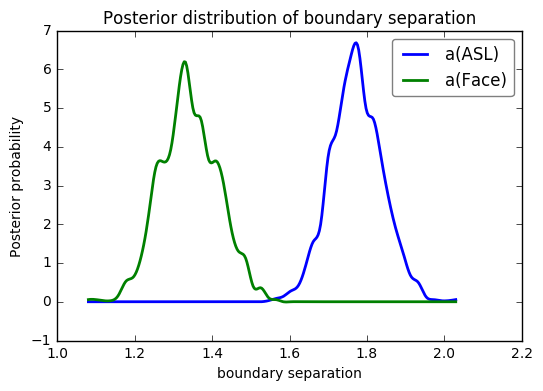

In [13]:
boundary_ASL, boundary_Face = m_stim.nodes_db.node[['a(ASL)', 'a(Face)']]
hddm.analyze.plot_posterior_nodes([boundary_ASL, boundary_Face])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation')

In [33]:
# write variable drift and boundary separation model output to csv
drift_ASL.trace().tofile("hddm_output/drift_asl.csv", sep=',', format='%10.5f')
drift_Face.trace().tofile("hddm_output/drift_face.csv", sep=',', format='%10.5f')
boundary_Face.trace().tofile("hddm_output/boundary_face.csv", sep=',', format='%10.5f')
boundary_ASL.trace().tofile("hddm_output/boundary_asl.csv", sep=',', format='%10.5f')

# Fit HDDM to adult data

Next, we fit the same HDDM for the adult data with the four different center stimulus types: face, bullseye, text, and text-no-audio

In [47]:
# fit model for adult data
m_adults = hddm.HDDM(data_adults, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_adults.find_starting_values()
m_adults.sample(3000, burn=20)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 3001 of 3000 complete in 383.3 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Plotting a(bullseye)
Plotting a(face)
Plotting a(text)
Plotting a(text-no-audio)
Plotting a_std
Plotting v(bullseye)
Plotting v(face)
Plotting v(text)
Plotting v(text-no-audio)
Plotting t(bullseye)
Plotting t(face)
Plotting t(text)
Plotting t(text-no-audio)


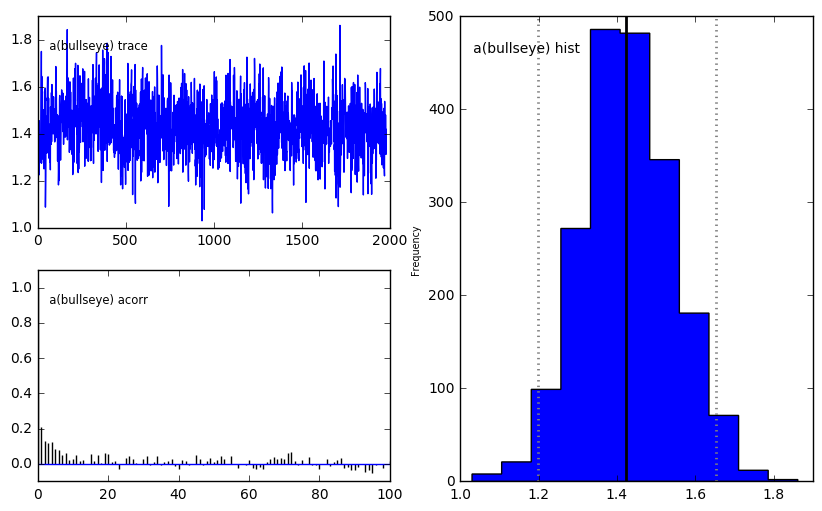

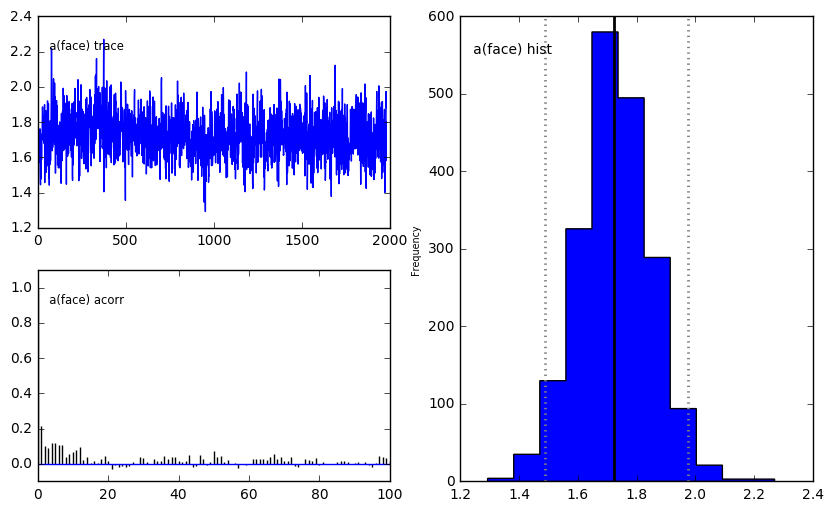

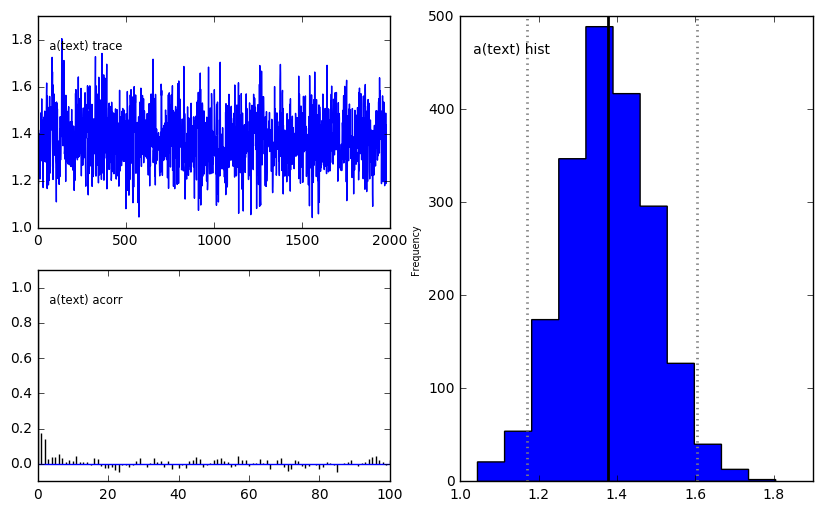

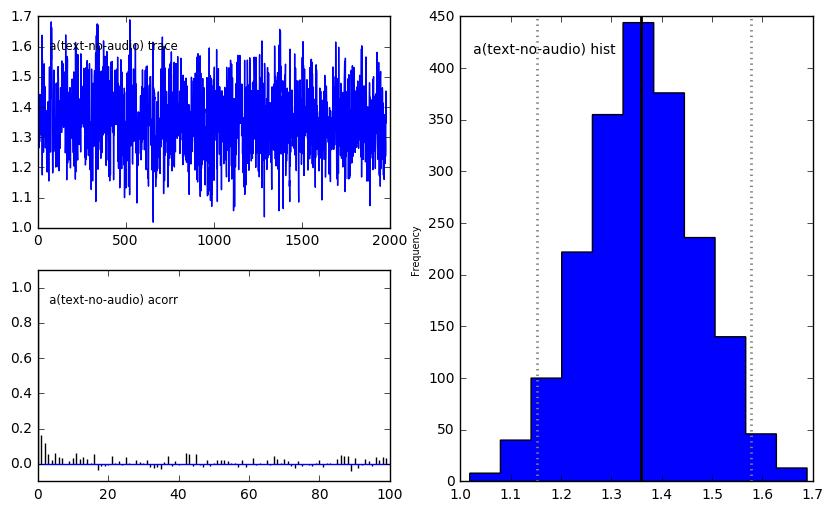

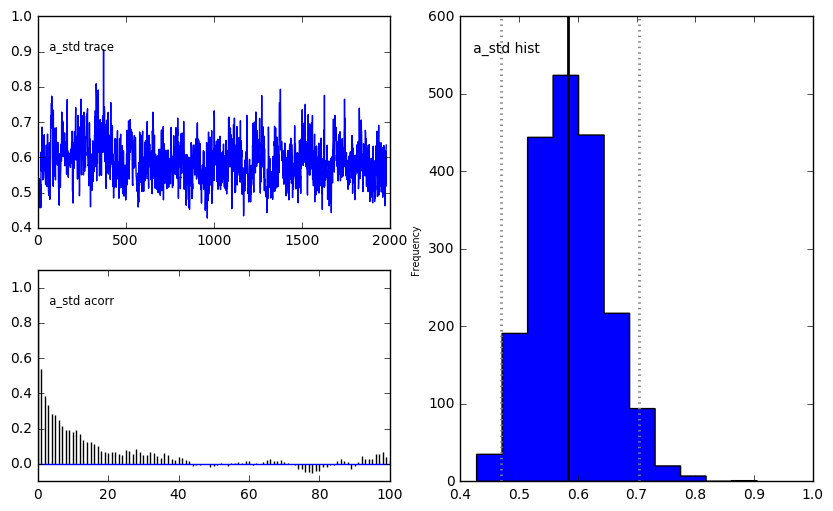

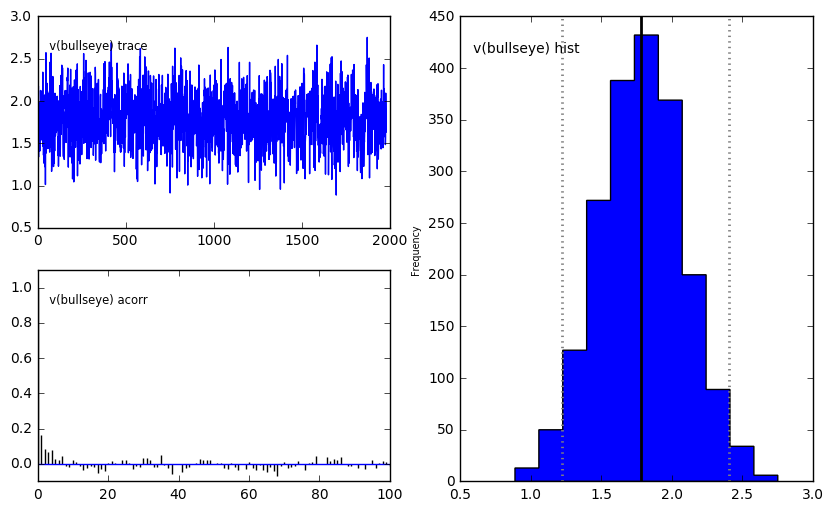

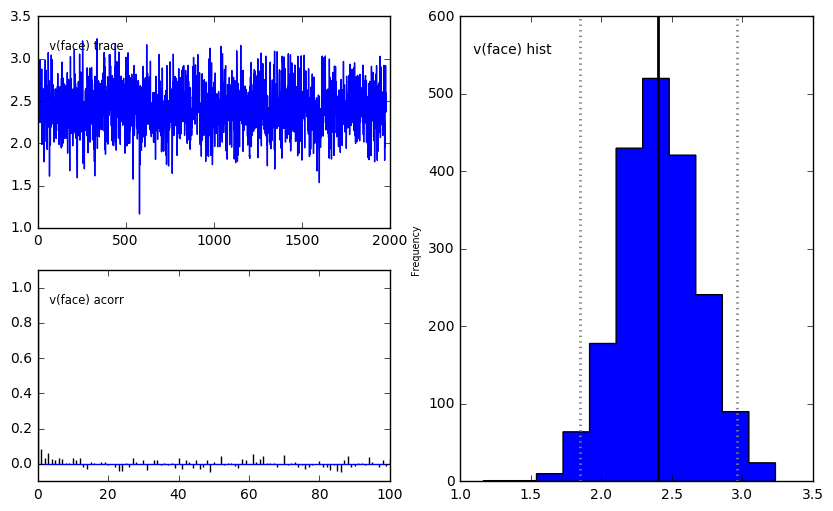

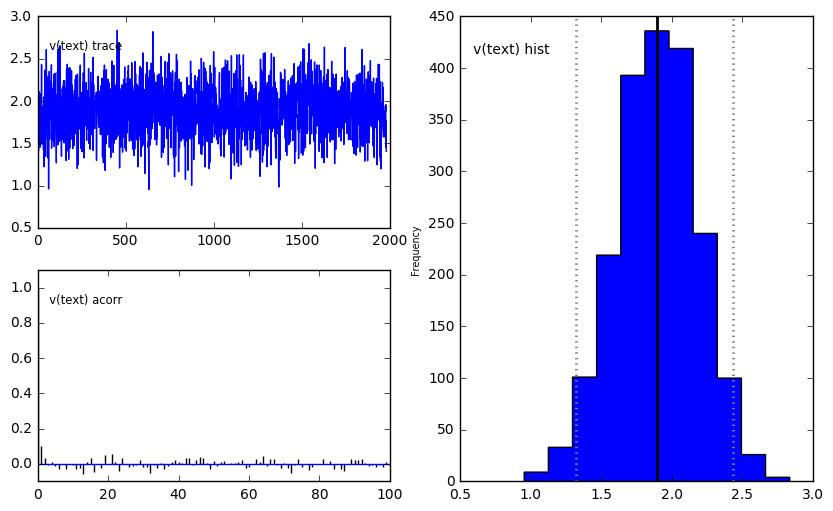

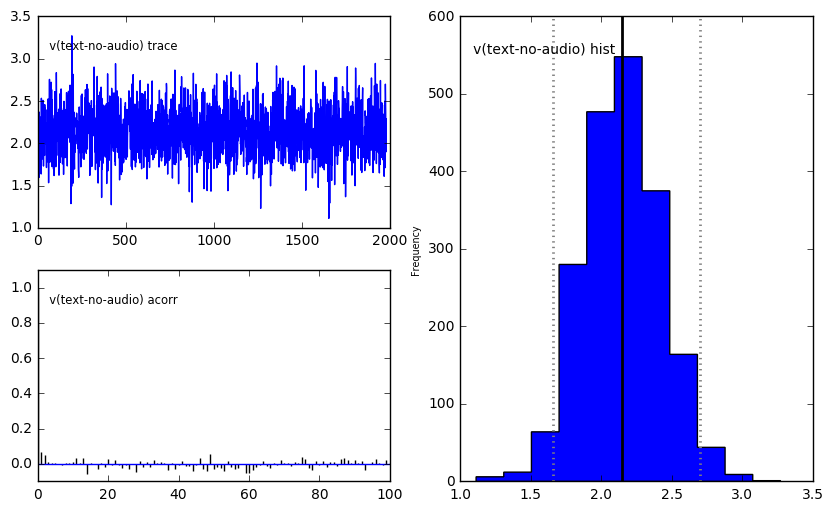

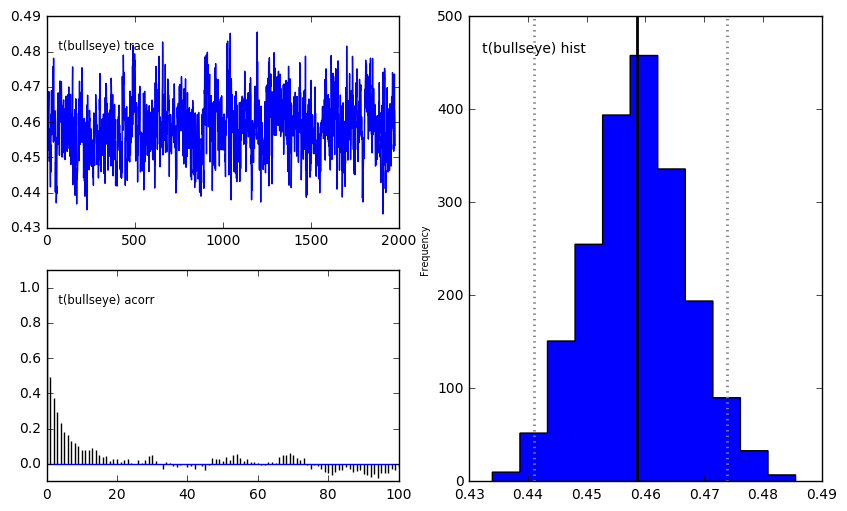

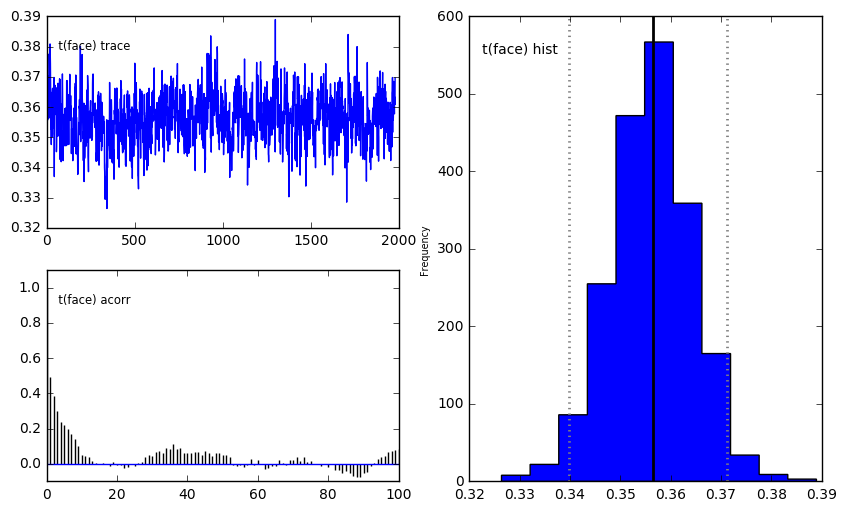

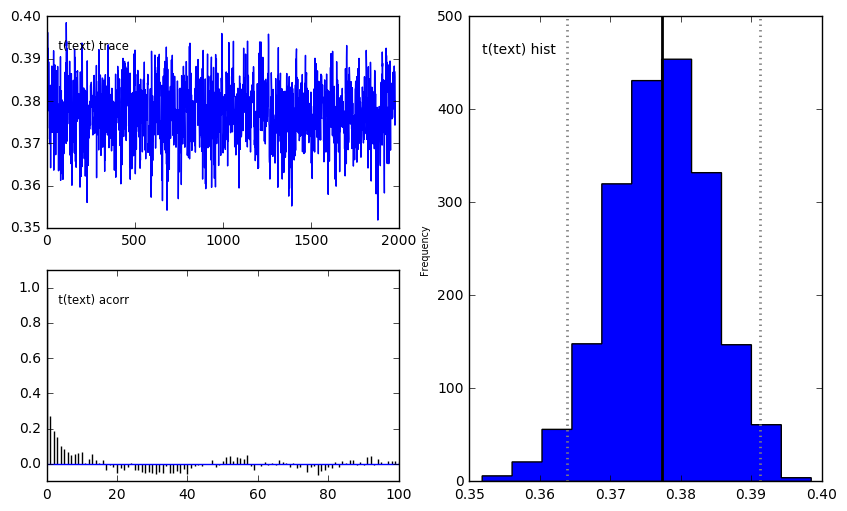

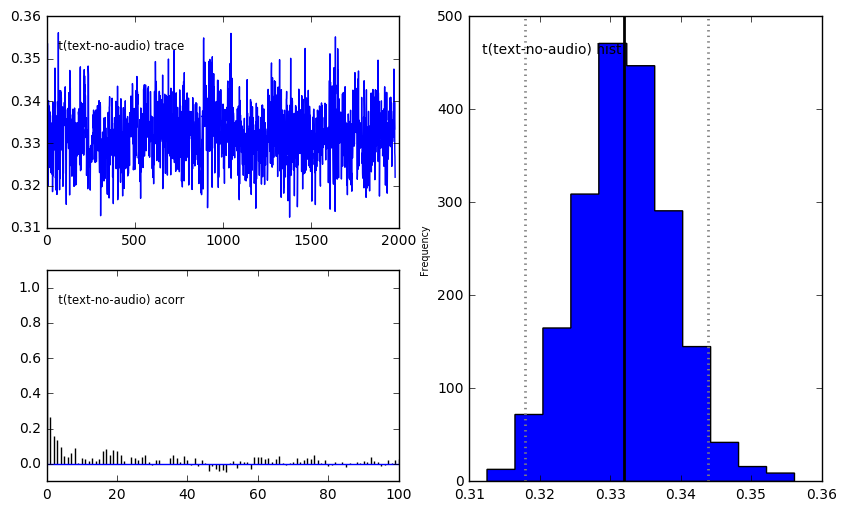

In [42]:
m_adults.plot_posteriors(['a', 't', 'v', 'a_std'])

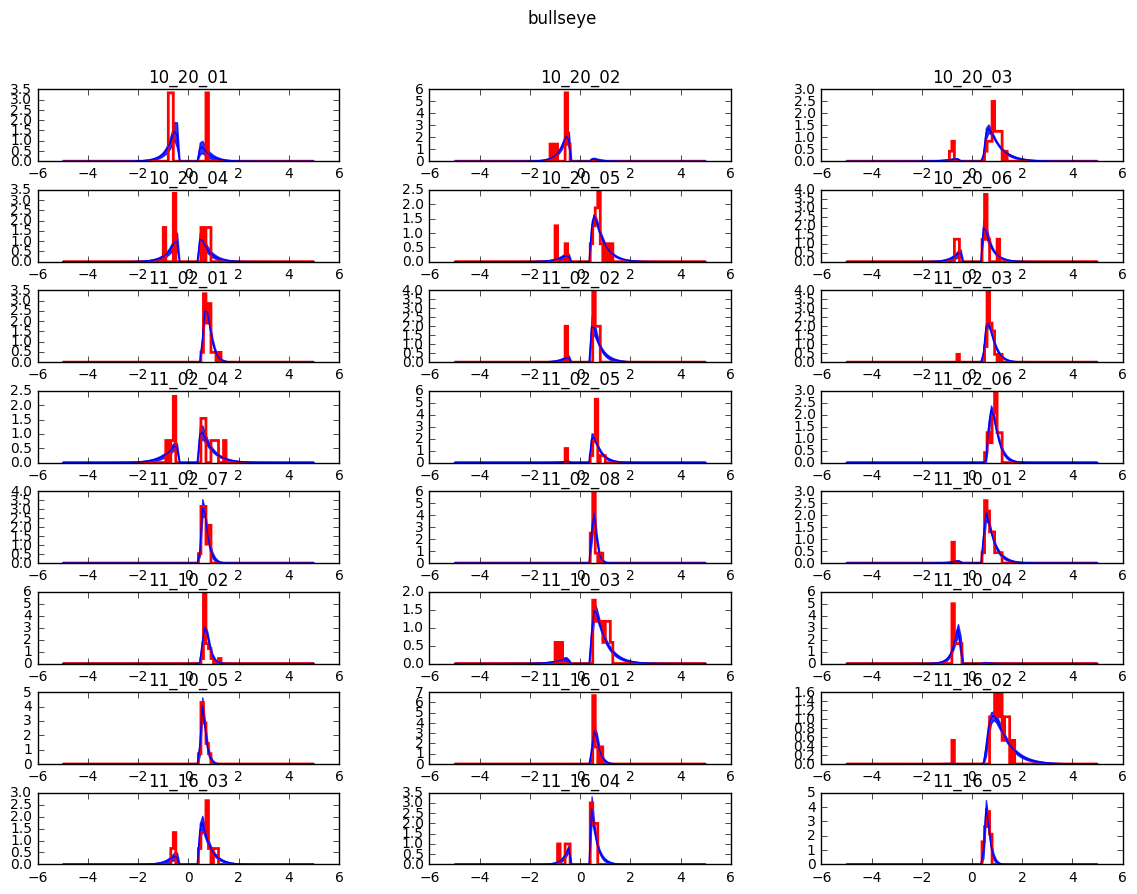

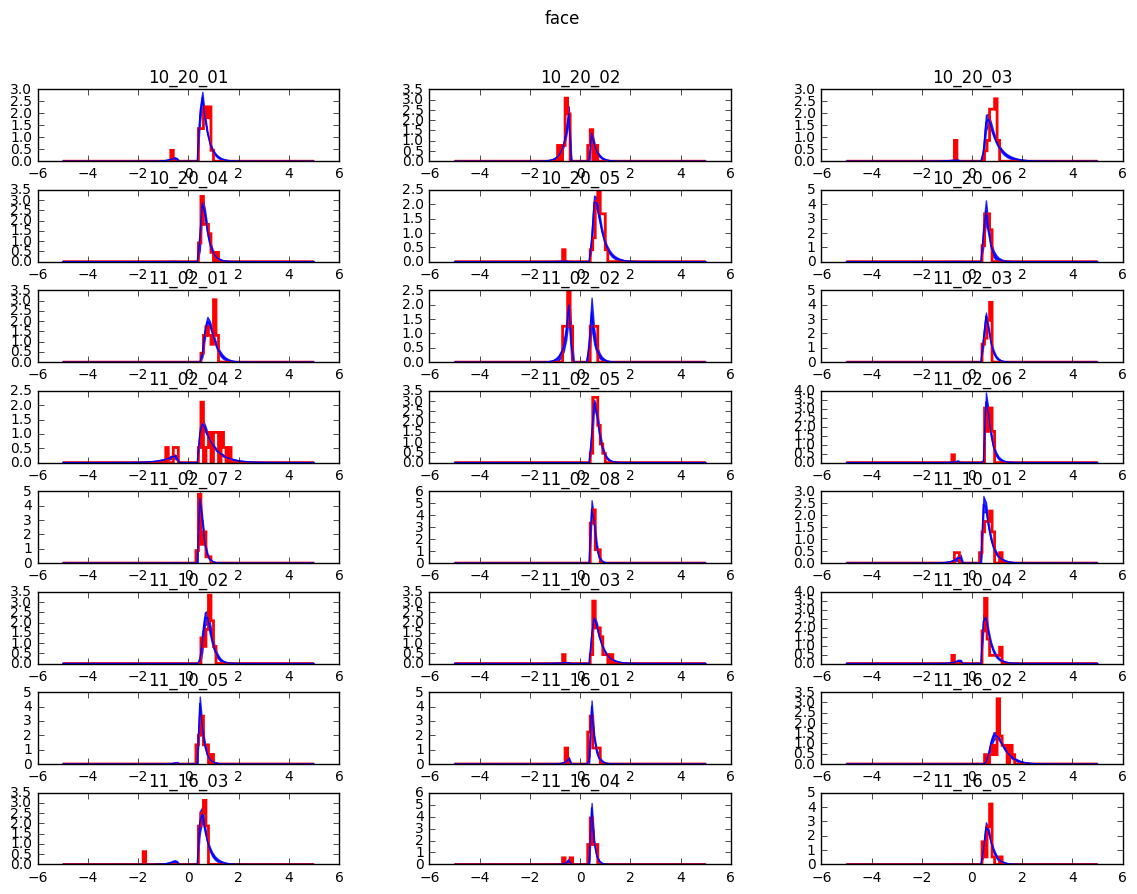

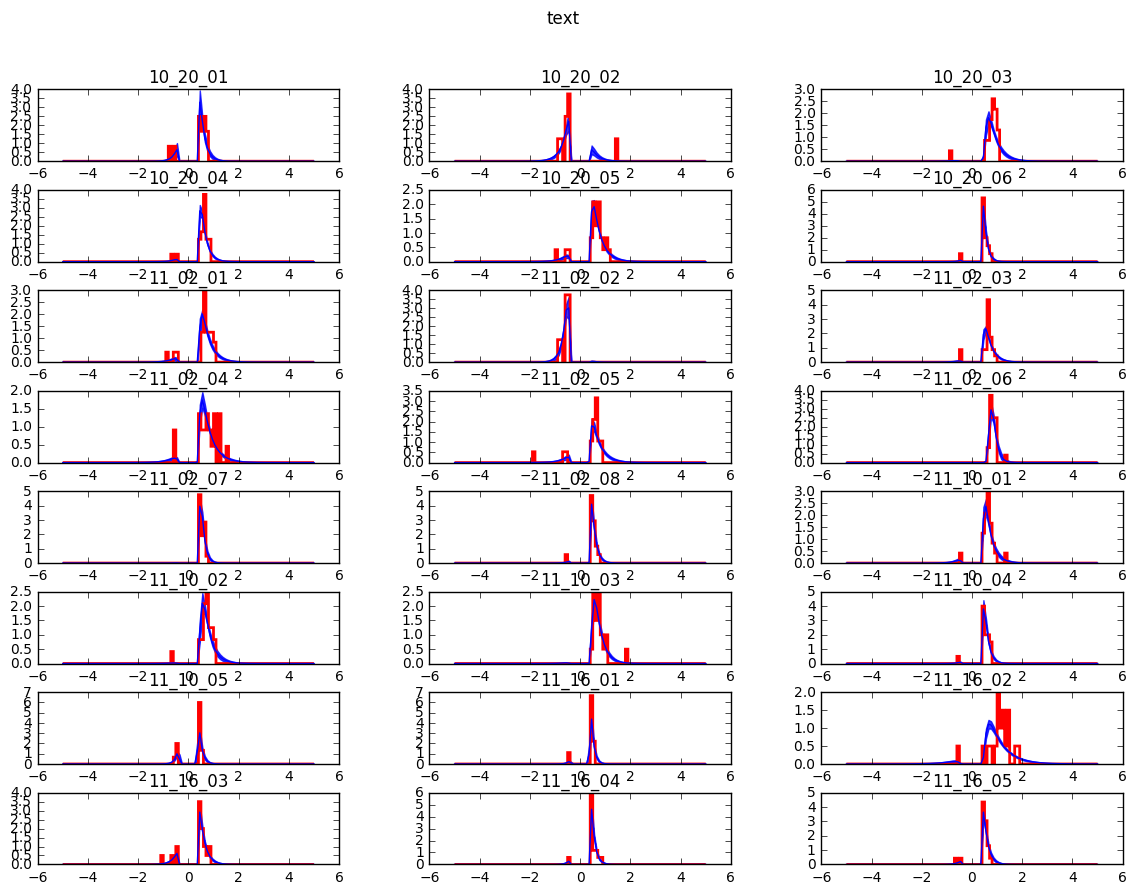

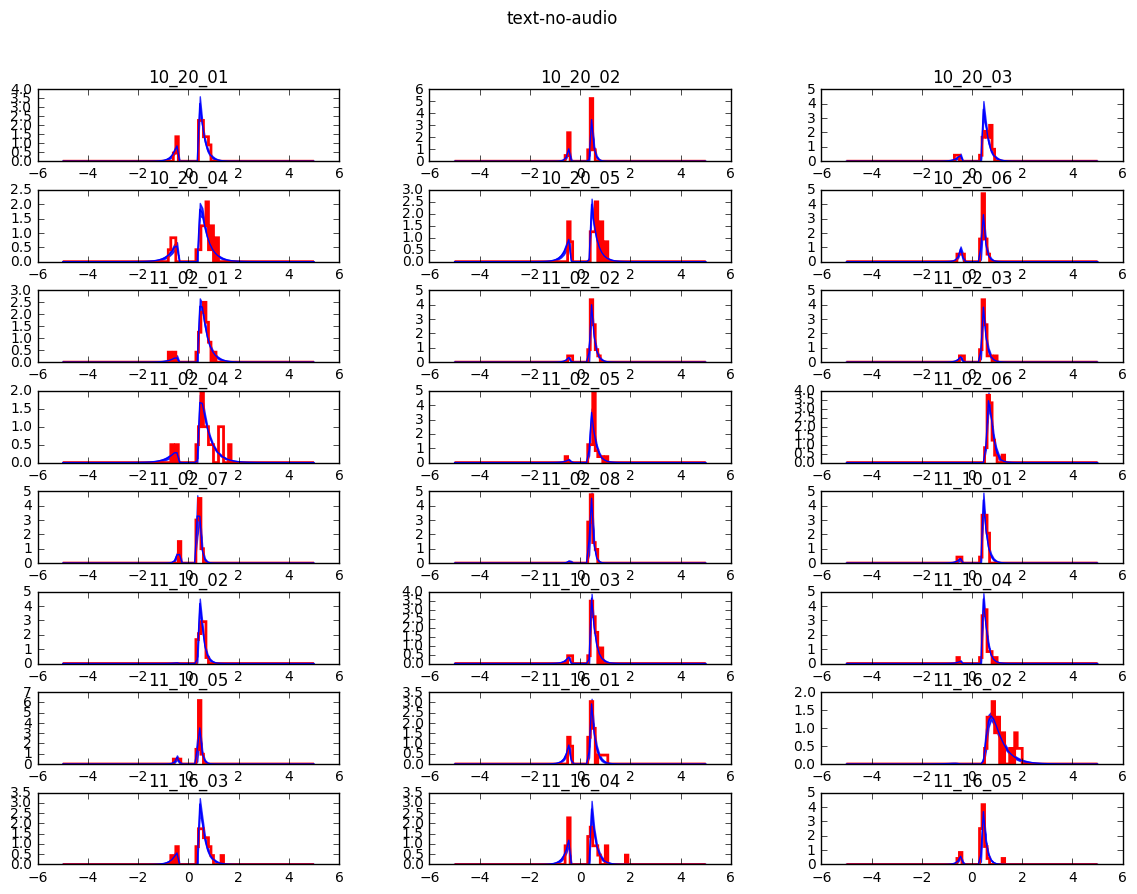

In [38]:
m_adults.plot_posterior_predictive(figsize=(14, 10))

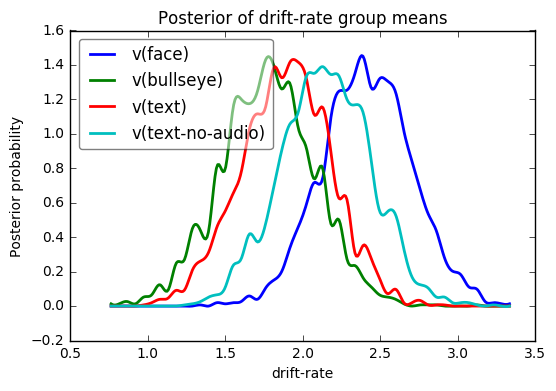

In [48]:
# plot drift
drift_face_adult, drift_bull_adult, drift_text_adult, drift_text_no_audio_adult = m_adults.nodes_db.node[['v(face)', 'v(bullseye)', 'v(text)', 'v(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([drift_face_adult, drift_bull_adult, drift_text_adult, drift_text_no_audio_adult])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

In [54]:
(drift_bull_adult.trace() > drift_face_adult.trace()).mean()


0.061409395973154361

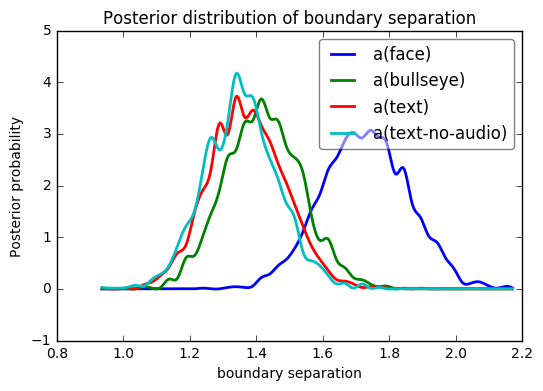

In [49]:
# plot boundary separation
boundary_face_adult, boundary_bull_adult, boundary_text_adult, boundary_text_no_audio_adult = m_adults.nodes_db.node[['a(face)', 'a(bullseye)', 'a(text)', 'a(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([boundary_face_adult, boundary_bull_adult, boundary_text_adult, boundary_text_no_audio_adult])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation')

In [55]:
(boundary_bull_adult.trace() > boundary_face_adult.trace()).mean()

0.031208053691275169

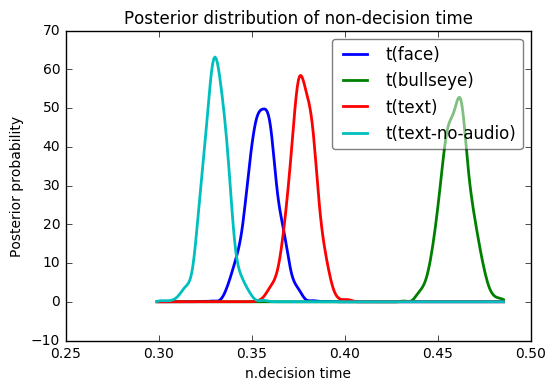

In [50]:
# plot nd time
nd_face_adult, nd_bull_adult, nd_text_adult, nd_text_no_audio_adult = m_adults.nodes_db.node[['t(face)', 't(bullseye)', 't(text)', 't(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([nd_face_adult, nd_bull_adult, nd_text_adult, nd_text_no_audio_adult])
plt.xlabel('n.decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of non-decision time')

In [58]:
# write variable drift model output to csv
drift_face_adult.trace().tofile("hddm_output/drift_face_adult.csv", sep=',', format='%10.5f')
drift_bull_adult.trace().tofile("hddm_output/drift_bull_adult.csv", sep=',', format='%10.5f')
drift_text_adult.trace().tofile("hddm_output/drift_text_adult.csv", sep=',', format='%10.5f')
drift_text_no_audio_adult.trace().tofile("hddm_output/drift_text_no_audio_adult.csv", sep=',', format='%10.5f')
# write boundary separation
boundary_face_adult.trace().tofile("hddm_output/boundary_face_adult.csv", sep=',', format='%10.5f')
boundary_bull_adult.trace().tofile("hddm_output/boundary_bull_adult.csv", sep=',', format='%10.5f')
boundary_text_adult.trace().tofile("hddm_output/boundary_text_adult.csv", sep=',', format='%10.5f')
boundary_text_no_audio_adult.trace().tofile("hddm_output/boundary_text_no_audio_adult.csv", sep=',', format='%10.5f')